## Time-based manual segmentation


In [14]:
import os
import pretty_midi
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import midi_utils as mu

plt.style.use("dark_background")

In [15]:
def split_midi_into_beats(input_file, output_folder, segment_length=8):
    """
    Splits a MIDI file into segments of segment_length beats each.

    Args:
    input_file (str): Path to the MIDI file.
    output_folder (str): Path to write the segments out to.
    segment_length (int): Number of beats in each segment.

    Returns:
    list[pretty_midi.PrettyMIDI]: A list of PrettyMIDI objects, each representing a segment of segment_length beats.
    """
    original_midi = pretty_midi.PrettyMIDI(input_file)
    beat_times = original_midi.get_beats()
    filename = Path(input_file).stem
    bpm = int(filename.split('-')[1])
    parent_length = round(original_midi.get_end_time(), 1)
    child_length = round(beat_times[segment_length - 1]/100 - beat_times[0]/100) * 100
    total_child_length = -1

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    segments = []
    for i in range(0, len(beat_times), segment_length):
        segment_midi = pretty_midi.PrettyMIDI(initial_tempo=bpm)
        start_time = beat_times[i]
        end_time = beat_times[min(i + segment_length, len(beat_times))] if (i + segment_length) < len(beat_times) else original_midi.get_end_time()
        output_filename = f'{filename}_{round(start_time)}-{round(end_time)}.mid'

        for instrument in original_midi.instruments:
            new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=output_filename)
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=note.start - start_time,
                        end=min(note.end, end_time) - start_time
                    )
                    new_instrument.notes.append(new_note)
            segment_midi.instruments.append(new_instrument)

        total_child_length += child_length
        segments.append(segment_midi)
        segment_midi.write(os.path.join(output_folder, output_filename))

    print(f"split {filename} into {round(len(beat_times)/segment_length)} segments of {segment_length} beats each")
    print(f"parent length {parent_length}s --> child length {child_length}s * {round(len(beat_times)/segment_length)} = {child_length * len(beat_times)/segment_length}, {total_child_length}")

    return segments


split 20240117-64-4-t_0-8 into 2 segments of 8 beats each
parent length 8.0s --> child length 0s * 2 = 0.0, -1


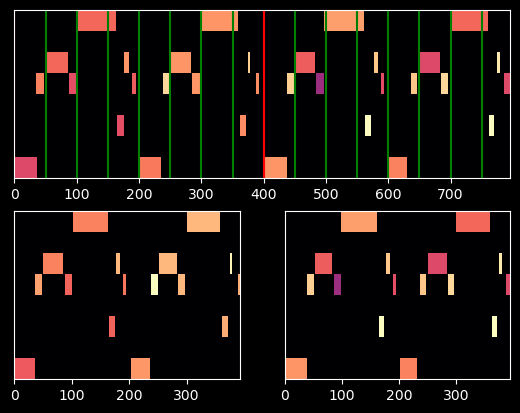

In [16]:
# midi_folder = os.path.join("data", "time", "20231220-80-1-t", "20231220-80-1-t_0-8.mid")
midi_folder = os.path.join("data", "trouble", "20240117-64-4-t", "20240117-64-4-t_0-8.mid")
dir_out = os.path.join("data", "beats-trouble")
fs = 100

midi = pretty_midi.PrettyMIDI(midi_folder)
piano_roll = midi.get_piano_roll(fs)
beats = midi.get_beats()
segments = split_midi_into_beats(midi_folder, dir_out, 8)

plt.subplot(2, 1, 1)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(piano_roll), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
for i, beat in enumerate(beats):
    color = 'r' if i % 8 == 0 else 'g'
    plt.axvline(x=beat * fs, color=color)

plt.subplot(2, 2, 3)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(segments[0].get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
    
plt.subplot(2, 2, 4)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(segments[1].get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.show()

In [17]:
print(mu.trim_piano_roll(piano_roll).shape)
for s in segments:
  print(mu.trim_piano_roll(s.get_piano_roll()).shape)

(8, 796)
(8, 393)
(8, 396)


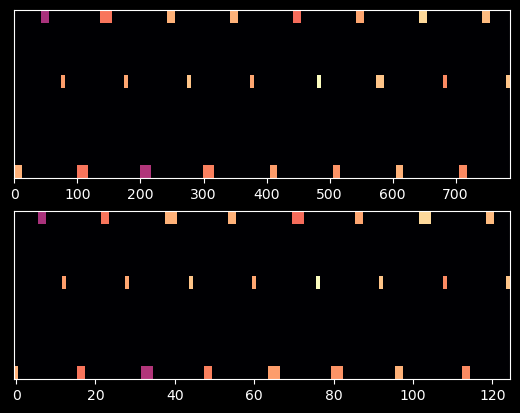

In [19]:
midi_folder = os.path.join("data", "time", "20231220-80-1-t", "20231220-80-1-t_0-8.mid")
dir_out = os.path.join("data", "beats")
bpm = 80
subds = 12

fpr= pretty_midi.PrettyMIDI(midi_folder)
qpr = mu.quantize_midi(midi_folder, subds)

qpr.write(os.path.join("data", "beats-quantized", "20231220-80-1-tq_0-8.mid"))

plt.subplot(2, 1, 1)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(qpr.get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.subplot(2, 1, 2)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(fpr.get_piano_roll(fs=round(1/(60/(bpm * subds))))), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.show()

In [23]:
bs_path = os.path.join("data", "beats")
all_in_path = os.path.join("data", "trimmed outputs")
final_out_path = os.path.join("data", "beats-quantized")
segments = []

for file in os.listdir(all_in_path):
  segments = split_midi_into_beats(os.path.join(all_in_path, file), bs_path, 8)

target_len = round(segments[0].get_piano_roll().shape[1]/100)*100
for segment in segments:
  seg_shape = segment.get_piano_roll().shape
  if seg_shape[1] != target_len:
    print(f"{segment.instruments[0].name} has bad length {seg_shape} (wanted {target_len})")

split 20240121-66-2-t into 9 segments of 8 beats each
parent length 35.8s --> child length 0s * 9 = 0.0, -1
split 20231228-72-1-t into 70 segments of 8 beats each
parent length 280.8s --> child length 0s * 70 = 0.0, -1
split 20240121-70-9-t into 36 segments of 8 beats each
parent length 144.0s --> child length 0s * 36 = 0.0, -1
split 20240121-66-3-t into 35 segments of 8 beats each
parent length 140.0s --> child length 0s * 35 = 0.0, -1
split 20240121-66-1-t into 29 segments of 8 beats each
parent length 115.8s --> child length 0s * 29 = 0.0, -1
split 20240121-70-8-t into 40 segments of 8 beats each
parent length 159.6s --> child length 0s * 40 = 0.0, -1
split 20240121-70-6-t into 36 segments of 8 beats each
parent length 146.0s --> child length 0s * 36 = 0.0, -1
split 20240117-64-3-t into 36 segments of 8 beats each
parent length 144.0s --> child length 0s * 36 = 0.0, -1
split 20240121-70-4-t into 64 segments of 8 beats each
parent length 254.0s --> child length 0s * 64 = 0.0, -1
spli